In [1]:
!pip install -U seaborn 

Defaulting to user installation because normal site-packages is not writeable


# Анализ прибыли и рисков добычи нефти в регионе

Добывающей компании «ГлавРосГосНефть» требуется смоделировать принятие решения о выборе региона для разработки скважин.
В нашем распоряжении пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

<font color='green'>Цель</font>

Построить модель машинного обучения, которая поможет определить регион, где добыча нефти принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap*.

<font color='green'>Задачи</font>

- исследовать данные;
- построить модель машинного обучения на основе линейной регрессии;
- оценить объём запасов;
- посчитать риски и прибыль для каждого региона;
- определить регион для добычи.

<font color='green'>Основные условия</font>

- основная метрика - RМSE
- требуемая вероятность убытков - < 2.5%
- бюджет - 10 млрд. руб.
- доход с 1 барреля - 450 руб.

<font color='green'>Файлы</font>

- `geo_data_0.csv`
- `geo_data_1.csv`
- `geo_data_2.csv`

<font color='green'>Признаки</font>

- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` - признаки точек.


<font color='green'>Целевой признак</font>

- `product` — объём запасов в скважине (тыс. баррелей).

<font color='green'>Содержание</font>

<h1><span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#Регион-1" data-toc-modified-id="Регион-1-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Регион 1</a></span></li><li><span><a href="#Регион-2" data-toc-modified-id="Регион-2-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Регион 2</a></span></li><li><span><a href="#Регион-3" data-toc-modified-id="Регион-3-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Регион 3</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span><ul class="toc-item"><li><span><a href="#Регион-1" data-toc-modified-id="Регион-1-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Регион 1</a></span></li><li><span><a href="#Регион-2" data-toc-modified-id="Регион-2-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Регион 2</a></span></li><li><span><a href="#Регион-3" data-toc-modified-id="Регион-3-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Регион 3</a></span></li></ul></li></ul></div>

## Загрузка и подготовка данных

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_1 = pd.read_csv('/ML/datasets/geo_data_0.csv')
data_1['region'] = '1'
data_2 = pd.read_csv('/ML/datasets/geo_data_1.csv')
data_2['region'] = '2'
data_3 = pd.read_csv('/ML/datasets/geo_data_2.csv')
data_3['region'] = '3'
data = pd.concat([data_1, data_2, data_3], axis=0, ignore_index=True)

In [4]:
data.drop(['region'], axis=1).duplicated().sum() 

0

In [5]:
data['id'].duplicated().sum() 

49

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       300000 non-null  object 
 1   f0       300000 non-null  float64
 2   f1       300000 non-null  float64
 3   f2       300000 non-null  float64
 4   product  300000 non-null  float64
 5   region   300000 non-null  object 
dtypes: float64(4), object(2)
memory usage: 13.7+ MB


Полные дубликаты и пропуски не выявлены. При этом следует отметить, что присутствуют дубликаты в столбце `id`.  Классы сбалансированы. 

Посмотрим подробнее на распределения.

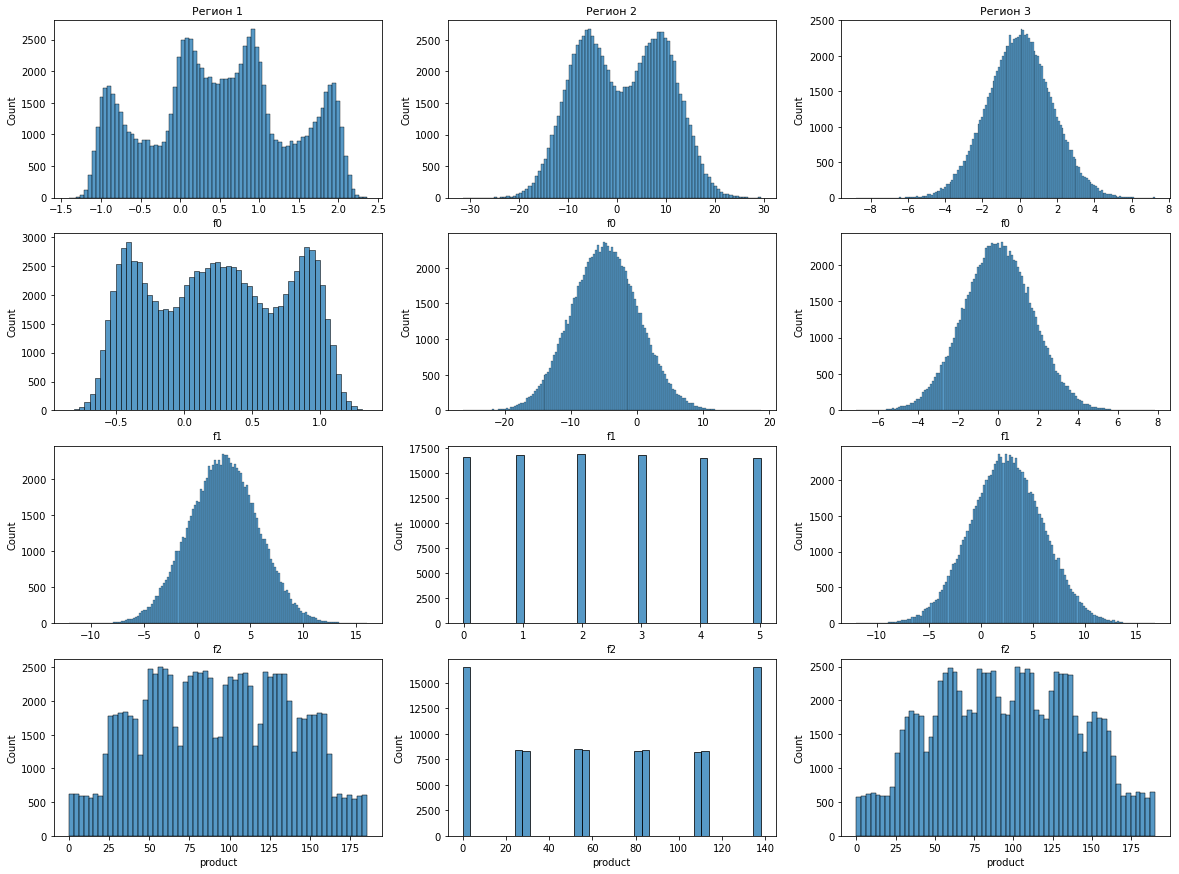

In [7]:
fig, axes = plt.subplots(4,3, figsize=(20,15))
x = 0
y = -1
for data in [data_1, data_2, data_3]:
    y +=1
    x = 0
    for column in ['f0', 'f1', 'f2', 'product']:
        sns.histplot(data = data, x = column, ax=axes[x, y])    
        x += 1   
axes[0,0].set_title('Регион 1', fontsize=11)
axes[0,1].set_title('Регион 2', fontsize=11)
axes[0,2].set_title('Регион 3', fontsize=11)
plt.show()

Вероятно, что данные `'f2'` и `'prodact'` по второму региону подготавливались по правилам, отличным от других регионов.

Посмотрим подробнее на корреляции.

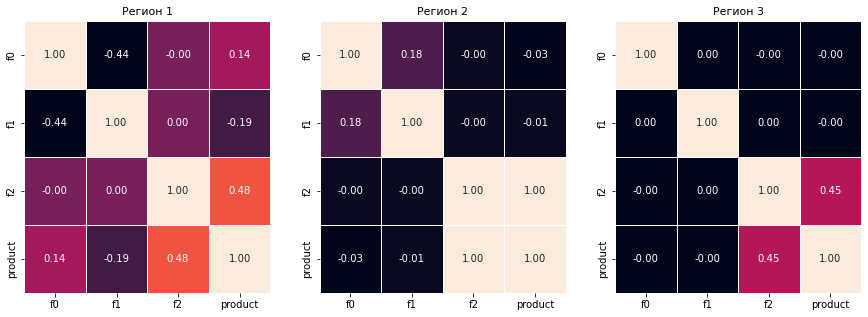

In [8]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

ax_1 = sns.heatmap(data_1.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f', ax=axes[0])
axes[0].set_title('Регион 1', fontsize=11)
ax_2 = sns.heatmap(data_2.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f', ax=axes[1])
axes[1].set_title('Регион 2', fontsize=11)
ax_3 = sns.heatmap(data_3.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f', ax=axes[2])
axes[2].set_title('Регион 3', fontsize=11)
plt.show()

Во втором регионе корреляция целевого признака с данными из `'f2'` равна единице, возможна утечка целевого признака. Требуется доп. проверка.

Будем строить модели для каждого региона по отдельности.

**Вывод**

Пропусков и полных дубликатов в данных не выявлено. В столбце `'id'` присутствуют 49 дубликатов. 

Между признаками `'f2'` и `'prodact'` для второго региона отмечается почти полная корреляция - возможна утечка целевого признака, требуется проверка данных. 

Вероятно также, что при формировании данных для районов применялись разные  правила.

## Обучение и проверка модели

Создадим функцию для оценки качества модели.

In [9]:
def quality(title):
    scorers = pd.DataFrame([np.sqrt(mean_squared_error(target_valid, predicted_valid)), predicted_valid.mean()],\
                           index=['RMSE', 'средний запас сырья'], columns=[title]).round(3).T
    print("на тренировочной выборке:\
    MAE - {:.3f}, RMSE - {:.3f}, средний запас сырья - {:.3f}".format\
                                      (mean_absolute_error(target_train, predicted_train),\
                                       np.sqrt(mean_squared_error(target_train, predicted_train)),\
                                       predicted_train.mean())) 
    print("на валидационной выборке:\
    MAE - {:.3f}, RMSE - {:.3f}, средний запас сырья - {:.3f}".format\
                                      (mean_absolute_error(target_valid, predicted_valid),\
                                       np.sqrt(mean_squared_error(target_valid, predicted_valid)),\
                                       predicted_valid.mean())) 
        
    return scorers

results = pd.DataFrame() #датафрейм для хранения результатов работы моделей

### Регион 1

Разобьём данные на тренировочную и валидационную.

In [10]:
target = data_1['product']
features = data_1.drop(['product', 'id', 'region'] , axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Проверим размеры полученных файлов.

In [11]:
print(features_train.shape, target_train.shape, features_valid.shape, target_valid.shape)

(75000, 3) (75000,) (25000, 3) (25000,)


Приведем признаки в столбцах `'f0'`, `'f1'`, `'f2'` к единому масштабу.

Создадим модель.

In [12]:
%%time

param_grid = {'fit_intercept':[True,False],
              'normalize':[True,False],
              'copy_X':[True, False]
}

model_1 = LinearRegression()
grid_search = GridSearchCV(model_1, param_grid, cv=5, refit='neg_mean_squared_error')
grid_search.fit(features_train, target_train)
predicted_train = grid_search.best_estimator_.predict(features_train)
predicted_valid = grid_search.best_estimator_.predict(features_valid)

target_1 = pd.DataFrame(target_valid).reset_index(drop=True)
prediction_1 = pd.DataFrame(predicted_valid)


results = quality('Регион 1').join(results) #сохранение и вывод результатов
print("Параметры лучшей модели:", grid_search.best_params_)

на тренировочной выборке:    MAE - 31.080, RMSE - 37.730, средний запас сырья - 92.640
на валидационной выборке:    MAE - 30.920, RMSE - 37.579, средний запас сырья - 92.593
Параметры лучшей модели: {'copy_X': True, 'fit_intercept': True, 'normalize': False}
CPU times: total: 3.7 s
Wall time: 676 ms


Проверим нашу модель на адекватность, сравнив с исскуственной моделью.

In [13]:
strategies = ['most_frequent', 'uniform']

for strategy in strategies:

    baseline_model = DummyClassifier(strategy = strategy, random_state = 12345)
    baseline_model.fit(features_train, target_train)

    predicted_train = baseline_model.predict(features_train)
    predicted_valid = baseline_model.predict(features_valid)
    
    print('Стратегия модели:', strategy)
    quality('title')

Стратегия модели: most_frequent
на тренировочной выборке:    MAE - 92.640, RMSE - 102.683, средний запас сырья - 0.000
на валидационной выборке:    MAE - 92.079, RMSE - 102.175, средний запас сырья - 0.000
Стратегия модели: uniform
на тренировочной выборке:    MAE - 50.930, RMSE - 62.550, средний запас сырья - 92.565
на валидационной выборке:    MAE - 50.896, RMSE - 62.540, средний запас сырья - 92.154


Проверку на адекватность наша модель прошла. 

### Регион 2

Разобьём данные на тренировочную и валидационную.

In [14]:
target = data_2['product']
features = data_2.drop(['product', 'id', 'region'] , axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Проверим размеры полученных файлов. 

In [15]:
print(features_train.shape, target_train.shape, features_valid.shape, target_valid.shape)

(75000, 3) (75000,) (25000, 3) (25000,)


Приведем признаки в столбцах `'f0'`, `'f1'`, `'f2'` к единому масштабу.

Создадим модель.

In [16]:
%%time

param_grid = {'fit_intercept':[True,False],
              'normalize':[True,False],
              'copy_X':[True, False]
}

model_2 = LinearRegression()
grid_search = GridSearchCV(model_2, param_grid, cv=5, refit='neg_mean_squared_error')
grid_search.fit(features_train, target_train)
predicted_train = grid_search.best_estimator_.predict(features_train)
predicted_valid = grid_search.best_estimator_.predict(features_valid)

target_2 = pd.DataFrame(target_valid).reset_index(drop=True)
prediction_2 = pd.DataFrame(predicted_valid)

results = pd.concat([results, quality('Регион 2')], axis=0, ignore_index=False)#сохранение и вывод результатов
print("Параметры лучшей модели:", grid_search.best_params_)

на тренировочной выборке:    MAE - 0.717, RMSE - 0.889, средний запас сырья - 68.859
на валидационной выборке:    MAE - 0.719, RMSE - 0.893, средний запас сырья - 68.729
Параметры лучшей модели: {'copy_X': True, 'fit_intercept': True, 'normalize': True}
CPU times: total: 3.81 s
Wall time: 636 ms


Проверим нашу модель на адекватность, сравнив с исскуственной моделью.

In [17]:
strategies = ['most_frequent', 'uniform']

for strategy in strategies:

    baseline_model = DummyClassifier(strategy = strategy, random_state = 12345)
    baseline_model.fit(features_train, target_train)

    predicted_train = baseline_model.predict(features_train)
    predicted_valid = baseline_model.predict(features_valid)
    
    print('Стратегия модели:', strategy)
    quality('title')

Стратегия модели: most_frequent
на тренировочной выборке:    MAE - 40.841, RMSE - 48.363, средний запас сырья - 84.039
на валидационной выборке:    MAE - 41.038, RMSE - 48.503, средний запас сырья - 84.039
Стратегия модели: uniform
на тренировочной выборке:    MAE - 52.498, RMSE - 64.945, средний запас сырья - 68.893
на валидационной выборке:    MAE - 52.797, RMSE - 65.149, средний запас сырья - 68.944


Проверку на адекватность наша модель прошла. 

### Регион 3

Разобьём данные на тренировочную и валидационную. 

In [18]:
target = data_3['product']
features = data_3.drop(['product', 'id', 'region'] , axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Проверим размеры полученных файлов. 

In [19]:
print(features_train.shape, target_train.shape, features_valid.shape, target_valid.shape)

(75000, 3) (75000,) (25000, 3) (25000,)


Приведем признаки в столбцах `'f0'`, `'f1'`, `'f2'` к единому масштабу.

Создадим модель.

In [20]:
%%time

param_grid = {'fit_intercept':[True,False],
              'normalize':[True,False],
              'copy_X':[True, False]
}

model_3 = LinearRegression()
grid_search = GridSearchCV(model_3, param_grid, cv=5, refit='neg_mean_squared_error')
grid_search.fit(features_train, target_train)
predicted_train = grid_search.best_estimator_.predict(features_train)
predicted_valid = grid_search.best_estimator_.predict(features_valid)

target_3 = pd.DataFrame(target_valid).reset_index(drop=True)
prediction_3 = pd.DataFrame(predicted_valid)

results = pd.concat([results, quality('Регион 3')], axis=0, ignore_index=False)#сохранение и вывод результатов
print("Параметры лучшей модели:", grid_search.best_params_)

на тренировочной выборке:    MAE - 32.839, RMSE - 40.064, средний запас сырья - 95.039
на валидационной выборке:    MAE - 32.793, RMSE - 40.030, средний запас сырья - 94.965
Параметры лучшей модели: {'copy_X': True, 'fit_intercept': True, 'normalize': True}
CPU times: total: 3.8 s
Wall time: 636 ms


Проверим нашу модель на адекватность, сравнив с исскуственной моделью:

In [21]:
strategies = ['most_frequent', 'uniform']

for strategy in strategies:

    baseline_model = DummyClassifier(strategy = strategy, random_state = 12345)
    baseline_model.fit(features_train, target_train)

    predicted_train = baseline_model.predict(features_train)
    predicted_valid = baseline_model.predict(features_valid)
    
    print('Стратегия модели:', strategy)
    quality('title')

Стратегия модели: most_frequent
на тренировочной выборке:    MAE - 95.024, RMSE - 105.012, средний запас сырья - 0.014
на валидационной выборке:    MAE - 94.870, RMSE - 104.960, средний запас сырья - 0.014
Стратегия модели: uniform
на тренировочной выборке:    MAE - 51.536, RMSE - 63.340, средний запас сырья - 94.967
на валидационной выборке:    MAE - 51.708, RMSE - 63.579, средний запас сырья - 94.552


Проверку на адекватность наша модель прошла.

**Вывод**

Результаты работы наших моделей на валидационной выборке выглядят следующим образом:

In [22]:
results

,RMSE,средний запас сырья
Регион 1,37.579,92.593
Регион 2,0.893,68.729
Регион 3,40.030,94.965


Для второго региона возможна утечка целевого признака, требуется дополнительная проверка данных.

## Подготовка к расчёту прибыли

Создадим основные константы для расчета прибыли.

In [23]:
BUDGET = 10000000000 
PROFIT_PER_UNIT = 450000 
COUNT = 200

Рассчитаем средний уровень сырья, достаточный для безубыточной разработки новой скважины:

In [24]:
print("Cредний уровень сырья, достаточный для безубыточной разработки: \
     {:.2f}".format(round(BUDGET/PROFIT_PER_UNIT/COUNT+0.01, 2))) 

Cредний уровень сырья, достаточный для безубыточной разработки:      111.12


Ранее полученные нами данные по среднему уровню сырья в регионах:

In [25]:
results['средний запас сырья']

Регион 1    92.593
Регион 2    68.729
Регион 3    94.965
Name: средний запас сырья, dtype: float64

**Вывод**

Cредний уровень сырья, достаточный для безубыточной разработки - `111.12` тыс. баррелей.

Средний предсказанный уровень сырья по всем трем районам ниже этого уровня.

## Расчёт прибыли и рисков 

Создадим функцию для расчета прибыли.

In [26]:
def profit(target, prediction, count):
    sorted = prediction.sort_values(by=0, ascending=False)
    selected = target[sorted.index][:count]
    return (PROFIT_PER_UNIT * selected.sum()- BUDGET) / 1000000

conclusion = pd.DataFrame() # для сохранения результатов

### Регион 1

Проведем процедуру Bootstrap.

In [27]:
state = RandomState(12345) 
values = []

for i in range(1000):
    
    prediction_subsample = prediction_1.sample(frac=0.02, replace=False, random_state=state)
    target_subsample = target_1['product'][prediction_subsample.index]
    res = profit(target_subsample, prediction_subsample, 200)
    values.append(res)    
values = pd.Series(values)
loss = (values < 0).mean() # доля отрицательной прибыли

lower = values.quantile(0.025)
upper = values.quantile(0.975)

mean = values.mean()

interval = round(lower, 2),round(upper, 2)
conclusion_1 = pd.DataFrame([mean, str(interval),loss*100], \
               index=['ср. прибыль(млн.руб)*', 'дов. 95% интервал', 'риск убытков (%)'], columns=['Регион 1']).T

conclusion = pd.concat([conclusion_1, conclusion], axis=0)

print("Средняя прибыль(млн.руб):             {:.2f}".format(mean))
print("Доверительный 95% интервал(млн.руб): [{:.2f},{:.2f}]".format(lower,upper))
print("Риск убытков: {:.2%}".format(loss))


Средняя прибыль(млн.руб):             380.71
Доверительный 95% интервал(млн.руб): [-126.95,879.61]
Риск убытков: 7.20%


### Регион 2

Проведем процедуру Bootstrap.

In [28]:
state = RandomState(12345) 
values = []

for i in range(1000):
    
    prediction_subsample = prediction_2.sample(frac=0.02, replace=False, random_state=state)
    target_subsample = target_2['product'][prediction_subsample.index]
    res = profit(target_subsample, prediction_subsample, 200)
    values.append(res)    
values = pd.Series(values)
loss = (values < 0).mean() # доля отрицательной прибыли

lower = values.quantile(0.025)
upper = values.quantile(0.975)

mean = values.mean()

interval = round(lower, 2),round(upper, 2)
conclusion_2 = pd.DataFrame([mean, str(interval),loss*100], \
               index=['ср. прибыль(млн.руб)*', 'дов. 95% интервал', 'риск убытков (%)'], columns=['Регион 2']).T

conclusion = pd.concat([conclusion, conclusion_2], axis=0)

print("Средняя прибыль(млн.руб):             {:.2f}".format(mean))
print("Доверительный 95% интервал(млн.руб): [{:.2f},{:.2f}]".format(lower,upper))
print("Риск убытков: {:.2%}".format(loss))

Средняя прибыль(млн.руб):             448.23
Доверительный 95% интервал(млн.руб): [70.90,892.99]
Риск убытков: 1.40%


### Регион 3

Проведем процедуру Bootstrap.

In [29]:
state = RandomState(12345) 
values = []

for i in range(1000):
    
    prediction_subsample = prediction_3.sample(frac=0.02, replace=False, random_state=state)
    target_subsample = target_3['product'][prediction_subsample.index]
    res = profit(target_subsample, prediction_subsample, 200)
    values.append(res)    
values = pd.Series(values)
loss = (values < 0).mean() # доля отрицательной прибыли

lower = values.quantile(0.025)
upper = values.quantile(0.975)

mean = values.mean()

interval = round(lower, 2),round(upper, 2)
conclusion_3 = pd.DataFrame([mean, str(interval),loss*100], \
               index=['ср. прибыль(млн.руб)*', 'дов. 95% интервал', 'риск убытков (%)'], columns=['Регион 3']).T

conclusion = pd.concat([conclusion, conclusion_3], axis=0)

print("Средняя прибыль(млн.руб):             {:.2f}".format(mean))
print("Доверительный 95% интервал(млн.руб): [{:.2f},{:.2f}]".format(lower,upper))
print("Риск убытков: {:.2%}".format(loss))

Средняя прибыль(млн.руб):             402.80
Доверительный 95% интервал(млн.руб): [-143.66,963.03]
Риск убытков: 7.10%


**Вывод**

Расчетные данные по регионам выглядят следующим образом:

In [30]:
conclusion

,ср. прибыль(млн.руб)*,дов. 95% интервал,риск убытков (%)
Регион 1,380.710891,"(-126.95, 879.61)",7.2
Регион 2,448.231065,"(70.9, 892.99)",1.4
Регион 3,402.796587,"(-143.66, 963.03)",7.1


`*` без учета налогов

Вероятность убытков < 2,5% наблюдается только по Региону №2. Этот регион предлагается в качестве целевого для разработки. 

При этом стоит помнить, что именно в данных по Региону №2 была отмечена сильная корреляция одного из признаков с целевым. Требуется дополнительная проверка входных данных. 